### Постановка общей задачи:



Нужно построить модель классификации, определяющую категорию цены подержанного автомобиля в зависимости от характеристик транспортного средства.

### Описание датасета:



- `id`: идентификатор записи;
- `url`: URL записи о продаже;
- `region`: регион;
- `region_url`: URL региона;
- `price`: стоимость;
- `year`: год выпуска;
- `manufacturer`: производитель;
- `model`: модель;
- `fuel`: тип топлива;
- `odometer`: количество пройденных миль;
- `title_status`: статус;
- `transmission`: коробка передач;
- `image_url`: URL изображения;
- `description`: указанное описание;
- `state`: штат;
- `lat`: широта;
- `long`: долгота;
- `posting_date`: дата размещения объявления о продаже;
- `price_category`: категория цены;
- `date`: дата публикации.

# 0. Импорт сторонних библиотек

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from matplotlib.ticker import FormatStrFormatter

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# 1. Загрузка данных

In [2]:
df = pd.read_csv("28.6_df_out.csv")

In [3]:
df.shape

(10000, 20)

In [4]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


# 2. Data Preparation

## Исследование данных на пропуски

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

In [6]:
# количество полностью заполненных объектов и их процент из всей выборки
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))
    
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 9507
Процент полностью заполненных объектов из всей выборки: 95.07


In [7]:
# процент пропущенных значений для каждого признака
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
print('Процент пропущенных значений:\n', missing_values)

Процент пропущенных значений:
 title_status      1.66
model             1.28
long              0.98
lat               0.98
fuel              0.63
transmission      0.45
year              0.36
posting_date      0.02
description       0.02
image_url         0.02
date              0.02
url               0.00
odometer          0.00
manufacturer      0.00
state             0.00
price             0.00
region_url        0.00
region            0.00
price_category    0.00
id                0.00
dtype: float64


In [8]:
# список всех признаков, в которых имеются пропущенные значения
missing_columns = missing_values[missing_values.values > 0].index.tolist()
missing_columns

['title_status',
 'model',
 'long',
 'lat',
 'fuel',
 'transmission',
 'year',
 'posting_date',
 'description',
 'image_url',
 'date']

### Обработка пропусков в годе выпуска автомобиля

In [9]:
# записи, в которых год выпуска автомобиля не заполнен
df[df.year.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
344,7304102133,https://wenatchee.craigslist.org/ctd/d/wenatch...,wenatchee,https://wenatchee.craigslist.org,35880,NaN,other,500,gas,13508,clean,automatic,https://images.craigslist.org/00J0J_6IMoEUzIIM...,2019 *Ram* *1500* Big Horn/Lone Star 4x2 Quad ...,wa,47.434493,-120.320759,2021-04-09T06:31:03-0700,high,2021-04-09 13:31:03+00:00
420,7316337069,https://lasvegas.craigslist.org/ctd/d/scottsda...,las vegas,https://lasvegas.craigslist.org,84995,NaN,other,Super Duty F-350 SRW,diesel,1268,clean,automatic,https://images.craigslist.org/00x0x_iQCC0Ef28S...,2020 *Ford* *Super Duty F-350 SRW* 1K MILES. B...,nv,33.458277,-111.925970,2021-05-03T11:31:39-0700,high,2021-05-03 18:31:39+00:00
425,7315662117,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,43900,NaN,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00f0f_7AwipNocNH...,"2019 *Dodge* *Grand Caravan* SE - $43,900Call ...",co,39.674406,-104.998604,2021-05-02T01:11:33-0600,high,2021-05-02 07:11:33+00:00
702,7316199009,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,https://nashville.craigslist.org,28498,NaN,other,olet Silverado 1500,NaN,59246,NaN,automatic,https://images.craigslist.org/00T0T_dZ7nOXskCS...,2019 *Chevrolet* *Silverado 1500* 2019 CHEVROL...,tn,36.138022,-86.732261,2021-05-03T10:00:40-0500,high,2021-05-03 15:00:40+00:00
893,7316840794,https://denver.craigslist.org/ctd/d/american-f...,denver,https://denver.craigslist.org,60900,NaN,other,F-150,gas,6110,clean,automatic,https://images.craigslist.org/01616_bpzSdSRTbx...,"2020 *Ford* *F-150* PLATINUM FX4 Truck - $60,9...",co,40.362248,-111.785947,2021-05-04T12:11:22-0600,high,2021-05-04 18:11:22+00:00
906,7311915616,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,67900,NaN,other,Odyssey,gas,21,clean,automatic,https://images.craigslist.org/00404_erlbeKWEkn...,2020 *Honda* *Odyssey* EX-L w/Navi/RES Automat...,co,39.674406,-104.998604,2021-04-24T10:41:06-0600,high,2021-04-24 16:41:06+00:00
1005,7306735187,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,38900,NaN,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00F0F_3T6FM0XMZW...,"2019 *Dodge* *Grand Caravan* SE - $38,900Call ...",co,39.674406,-104.998604,2021-04-14T10:51:36-0600,high,2021-04-14 16:51:36+00:00
1217,7309954650,https://gainesville.craigslist.org/ctd/d/gaine...,gainesville,https://gainesville.craigslist.org,24975,NaN,other,CR-V,gas,44128,clean,automatic,https://images.craigslist.org/00000_2TUtAgLlCR...,"2019 *Honda* *CR-V* EX 2WD SUV - $24,975Call o...",fl,29.676827,-82.319202,2021-04-20T14:46:55-0400,high,2021-04-20 18:46:55+00:00
1319,7313865045,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,47900,NaN,other,a Sienna,gas,43701,clean,automatic,https://images.craigslist.org/00o0o_8XYp4Zygdj...,2018 *Toyota* *Sienna* LE Automatic Access Sea...,co,39.674406,-104.998604,2021-04-28T10:12:14-0600,high,2021-04-28 16:12:14+00:00
1845,7303344554,https://daytona.craigslist.org/ctd/d/new-smyrn...,daytona beach,https://daytona.craigslist.org,35850,NaN,other,Transit Cargo Van,gas,567,clean,automatic,https://images.craigslist.org/00a0a_d4XVrHnlxl...,"2020 *Ford* *Transit Cargo Van* T-250 148"" WB*...",fl,29.046240,-80.934561,2021-04-07T17:10:06-0400,high,2021-04-07 21:10:06+00:00


In [10]:
# удаляем записи, в которых год выпуска автомобиля не заполнен
df = df[df.year.notna()]
df.shape

(9964, 20)

In [11]:
print("Количество пропущенных значений в year:", df.year.isna().sum())

Количество пропущенных значений в year: 0


### Обработка пропусков в виде топлива автомобиля

In [12]:
# количество значений для типа топлива, включая пропущенные значения
df.fuel.value_counts(dropna=False)

fuel
gas         8379
other        729
diesel       650
hybrid       108
NaN           54
electric      44
Name: count, dtype: int64

In [13]:
# записи, в которых типа топлива автомобиля не заполнен
df[df.fuel.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
32,7309910590,https://eugene.craigslist.org/ctd/d/eugene-200...,eugene,https://eugene.craigslist.org,4977,2001.0,toyota,camry solara 2dr cpe se v6 auto (natl),NaN,193242,clean,automatic,https://images.craigslist.org/00F0F_ebtJlxCQjv...,***Call Us for more information at: 541-228-94...,or,44.076513,-123.150156,2021-04-20T10:40:15-0700,low,2021-04-20 17:40:15+00:00
78,7314559074,https://eugene.craigslist.org/ctd/d/eugene-200...,eugene,https://eugene.craigslist.org,27977,2009.0,ford,"f-150 4wd supercrew 145"" platinum",NaN,79522,clean,automatic,https://images.craigslist.org/00L0L_khoMmqXaSJ...,***Call Us for more information at: 541-228-94...,or,44.076513,-123.150156,2021-04-29T15:15:30-0700,high,2021-04-29 22:15:30+00:00
275,7315141987,https://honolulu.craigslist.org/oah/ctd/d/fort...,hawaii,https://honolulu.craigslist.org,29888,2019.0,nissan,frontier crew cab 4x2 sv auto,NaN,10679,clean,automatic,https://images.craigslist.org/00F0F_d9wEXQuSyu...,***Call Us for more information at: 877-262-34...,hi,21.344376,-157.896975,2021-04-30T15:50:19-1000,high,2021-05-01 01:50:19+00:00
471,7316807613,https://eugene.craigslist.org/ctd/d/eugene-200...,eugene,https://eugene.craigslist.org,13436,2006.0,chevrolet,"silverado 1500 ext cab 143.5"" wb 4wd ls",NaN,172700,clean,automatic,https://images.craigslist.org/00l0l_35tV0gQdD8...,***Call Us for more information at: 541-228-94...,or,44.076513,-123.150156,2021-05-04T10:20:19-0700,medium,2021-05-04 17:20:19+00:00
1009,7314561306,https://cnj.craigslist.org/ctd/d/parlin-2000-c...,central NJ,https://cnj.craigslist.org,5894,2000.0,chevrolet,"s-10 ext cab 123"" wb ls",NaN,78740,clean,automatic,https://images.craigslist.org/00O0O_8vd70bT1rY...,***Call Us for more information at: 732-316-55...,nj,40.468650,-74.296990,2021-04-29T18:20:19-0400,low,2021-04-29 22:20:19+00:00
1279,7310297136,https://westernmass.craigslist.org/ctd/d/johns...,western massachusetts,https://westernmass.craigslist.org,6000,2008.0,other,IC IC,NaN,0,NaN,automatic,https://images.craigslist.org/00404_cBFpBKbfr2...,"2008 *IC* *IC* CE300 - $6,000Call Us Today! 85...",ma,43.008105,-74.352011,2021-04-21T10:11:05-0400,low,2021-04-21 14:11:05+00:00
1318,7310414739,https://nwct.craigslist.org/ctd/d/melville-200...,northwest CT,https://nwct.craigslist.org,11995,2007.0,gmc,c-7500 multiple uses perfect,NaN,50098,clean,automatic,https://images.craigslist.org/00T0T_jvsOAKSGAr...,2007 *GMC* *C-7500 MULTIPLE USES PERFECT* FOR ...,ct,40.681179,-73.430488,2021-04-21T13:18:41-0400,medium,2021-04-21 17:18:41+00:00
1686,7316342709,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,19942,2017.0,ram,"promaster cargo van 1500 low roof 118"" wb",NaN,88836,clean,automatic,https://images.craigslist.org/00707_6ZlIIpYmGf...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T14:40:24-0400,medium,2021-05-03 18:40:24+00:00
1847,7315151536,https://honolulu.craigslist.org/oah/ctd/d/fort...,hawaii,https://honolulu.craigslist.org,29988,2019.0,toyota,sienna le fwd 8-passenger (natl),NaN,18762,clean,automatic,https://images.craigslist.org/00R0R_dO0gtiRwLa...,***Call Us for more information at: 877-262-34...,hi,21.344376,-157.896975,2021-04-30T16:25:22-1000,high,2021-05-01 02:25:22+00:00


In [14]:
# заполняем незаполненные значения типа топлива значением `other`
df.fuel = df.fuel.fillna('other')

In [15]:
print("Количество пропущенных значений в fuel:", df.fuel.isna().sum())

Количество пропущенных значений в fuel: 0


### Обработка пропусков в модели автомобиля

In [16]:
# количество значений для модели автомобиля, включая пропущенные значения
df.model.value_counts(dropna=False)

model
f-150                        151
NaN                          126
silverado 1500               110
1500                         100
camry                         77
                            ... 
sorrento lx v6                 1
sierra1500 crewcab 4x4         1
corolla se                     1
xc60 t6 inscription sport      1
a3 2.0t premium plus pzev      1
Name: count, Length: 3447, dtype: int64

In [17]:
# описательные статистики для модели автомобиля
df.model.describe()

count      9838
unique     3446
top       f-150
freq        151
Name: model, dtype: object

In [18]:
# записи, в которых модель автомобиля не заполнена
df[df.model.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
67,7316913641,https://ventura.craigslist.org/cto/d/camarillo...,ventura county,https://ventura.craigslist.org,3000,2005.0,rover,NaN,gas,165206,clean,automatic,https://images.craigslist.org/00S0S_b3yx6L4N2S...,2005 Range Rover HSE Changed Oil and now engi...,ca,34.219565,-119.001986,2021-05-04T13:11:15-0700,low,2021-05-04 20:11:15+00:00
142,7316550853,https://chicago.craigslist.org/chc/cto/d/midlo...,chicago,https://chicago.craigslist.org,3000,2006.0,jeep,NaN,gas,132000,clean,automatic,https://images.craigslist.org/01111_kNv3EKjH4H...,SUPER CLEAN 2006 JEEP LIBEERY RANAGADE 4X4 O...,il,41.618957,-87.726334,2021-05-03T20:33:40-0500,low,2021-05-04 01:33:40+00:00
151,7303575863,https://worcester.craigslist.org/ctd/d/fitchbu...,worcester / central MA,https://worcester.craigslist.org,7800,2007.0,gmc,NaN,gas,190000,clean,automatic,https://images.craigslist.org/00f0f_iWjiToqea2...,2007 gmc with plow leather loaded nice truck r...,ma,42.579600,-71.803100,2021-04-08T09:10:07-0400,low,2021-04-08 13:10:07+00:00
200,7315267860,https://gainesville.craigslist.org/ctd/d/kissi...,gainesville,https://gainesville.craigslist.org,19200,2012.0,ram,NaN,gas,121371,clean,automatic,https://images.craigslist.org/00W0W_hHV4D0Po0G...,2012 RAM 1500 Laramie Crew Cab 2WD Offered...,fl,28.329026,-81.404237,2021-05-01T10:05:17-0400,medium,2021-05-01 14:05:17+00:00
251,7316024407,https://reading.craigslist.org/ctd/d/paterson-...,reading,https://reading.craigslist.org,18695,2007.0,ram,NaN,diesel,220019,clean,automatic,https://images.craigslist.org/00n0n_jgq4eOvH7I...,2007 Dodge Ram 2500 SLT 4x4 Quad Cab Cummins D...,pa,40.894535,-74.152367,2021-05-02T21:06:09-0400,medium,2021-05-03 01:06:09+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9564,7314341390,https://desmoines.craigslist.org/cto/d/urbanda...,des moines,https://desmoines.craigslist.org,8000,2007.0,toyota,NaN,gas,85285,clean,automatic,https://images.craigslist.org/00K0K_aMoJgOIueB...,Toyota has been owned by non smoker with no pe...,ia,41.629500,-93.723000,2021-04-29T10:50:54-0500,low,2021-04-29 15:50:54+00:00
9616,7304358131,https://vermont.craigslist.org/ctd/d/salem-201...,vermont,https://vermont.craigslist.org,19944,2012.0,ram,NaN,gas,73082,clean,automatic,https://images.craigslist.org/00A0A_bfCaGJ20IX...,2012 RAM 1500 4WD REGULAR CAB SHORT BED 5.7 HE...,vt,42.788204,-71.233728,2021-04-09T16:24:23-0400,medium,2021-04-09 20:24:23+00:00
9670,7309686008,https://louisville.craigslist.org/cto/d/radcli...,louisville,https://louisville.craigslist.org,1600,2005.0,gmc,NaN,gas,52536,clean,automatic,https://images.craigslist.org/01111_99unV6cYER...,GMC Savana PRO AWD cargo van has been driven l...,ky,37.858900,-86.006900,2021-04-20T04:48:30-0400,low,2021-04-20 08:48:30+00:00
9926,7316447901,https://tulsa.craigslist.org/cto/d/tulsa-2017-...,tulsa,https://tulsa.craigslist.org,65000,2017.0,rover,NaN,gas,47000,clean,automatic,https://images.craigslist.org/00s0s_iGpmplDL99...,"2017 Range Rover HSE, supercharged V8, silver ...",ok,36.126200,-95.940800,2021-05-03T16:37:36-0500,high,2021-05-03 21:37:36+00:00


In [19]:
# обработаем пропуски, заполнив незаполненные значения модели автомобиля значением `other`
df.model = df.model.fillna('other')

In [20]:
print("Количество пропущенных значений в model:", df.model.isna().sum())

Количество пропущенных значений в model: 0


### Обработка пропусков в статусе автомобиля

In [21]:
# количество значений для статуса автомобиля, включая пропущенные значения
df.title_status.value_counts(dropna=False)

title_status
clean         9492
rebuilt        168
NaN            159
salvage         92
lien            35
missing         16
parts only       2
Name: count, dtype: int64

In [22]:
# записи, в которых статус автомобиля не заполнен
df[df.title_status.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
11,7316540706,https://cincinnati.craigslist.org/ctd/d/fairfi...,cincinnati,https://cincinnati.craigslist.org,4995,2012.0,fiat,500 pop,gas,59242,NaN,manual,https://images.craigslist.org/00Z0Z_jbUmVcYlwR...,"2012 Fiat 500 Pop FOR ONLY $102/mo!59,242 mi. ...",oh,39.297045,-84.563243,2021-05-03T21:03:32-0400,low,2021-05-04 01:03:32+00:00
187,7313570594,https://orangecounty.craigslist.org/ctd/d/coro...,orange county,https://orangecounty.craigslist.org,17900,2013.0,ram,1500 tradesman quad cab,gas,145499,NaN,automatic,https://images.craigslist.org/00H0H_1JFMPCYyW8...,2013 Ram 1500 Tradesman Quad Cab PRICED TO SEL...,ca,33.873436,-117.542806,2021-04-27T15:03:47-0700,medium,2021-04-27 22:03:47+00:00
245,7315211652,https://ocala.craigslist.org/ctd/d/riverview-2...,ocala,https://ocala.craigslist.org,40990,2019.0,toyota,sienna xle,gas,3700,NaN,automatic,https://images.craigslist.org/01111_grKNF8GrXz...,2019 Toyota Sienna - Wheelchair Accessible Han...,fl,27.849760,-82.364950,2021-05-01T06:35:56-0400,high,2021-05-01 10:35:56+00:00
286,7306702976,https://toledo.craigslist.org/ctd/d/chelsea-73...,toledo,https://toledo.craigslist.org,4592,2003.0,chevrolet,avalanche 1500,gas,268691,NaN,automatic,https://images.craigslist.org/00808_1IOMJuA4GL...,$73/mo - 2003 Chevrolet Avalanche 1500 BaseCre...,oh,42.300673,-84.024108,2021-04-14T12:03:01-0400,low,2021-04-14 16:03:01+00:00
312,7307609203,https://roseburg.craigslist.org/ctd/d/eugene-2...,roseburg,https://roseburg.craigslist.org,18450,2017.0,ford,mustang,gas,66049,NaN,automatic,https://images.craigslist.org/00505_4apF36sLbP...,"2017 Ford MUSTANG - $18,450 \tMayberry Motors ...",or,44.058499,-123.106176,2021-04-16T04:06:29-0700,medium,2021-04-16 11:06:29+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9740,7301707830,https://tricities.craigslist.org/ctd/d/bristol...,tri-cities,https://tricities.craigslist.org,8995,2013.0,honda,odyssey,gas,203112,NaN,automatic,https://images.craigslist.org/00u0u_bawW7HN8xW...,"2013 *Honda* *Odyssey* 5dr EX Van FWD - $8,995...",tn,36.541821,-82.234645,2021-04-04T13:12:27-0400,low,2021-04-04 17:12:27+00:00
9805,7313949726,https://harrisburg.craigslist.org/ctd/d/brockp...,harrisburg,https://harrisburg.craigslist.org,8900,2012.0,honda,accord,other,95674,NaN,NaN,https://images.craigslist.org/01212_dsfYRNhxfd...,Car Starz Call Sales at 717-401-4221 2012 Hond...,pa,41.261540,-78.704520,2021-04-28T14:25:32-0400,low,2021-04-28 18:25:32+00:00
9840,7314987181,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,https://nashville.craigslist.org,20900,2014.0,lexus,rx 350,gas,70800,NaN,automatic,https://images.craigslist.org/00Q0Q_cGablAkoYV...,2014 *Lexus* *RX 350* 2014 LEXUS RX 350 SUV 1-...,tn,36.138022,-86.732261,2021-04-30T15:00:48-0500,medium,2021-04-30 20:00:48+00:00
9856,7309717260,https://savannah.craigslist.org/ctd/d/jacksonv...,savannah / hinesville,https://savannah.craigslist.org,11495,2006.0,lexus,gx 470,gas,242000,NaN,automatic,https://images.craigslist.org/00s0s_8xg4gw6aAg...,"2006 *Lexus* *GX 470* 4dr SUV 4WD - $11,495By ...",ga,30.513566,-81.621875,2021-04-20T08:01:49-0400,medium,2021-04-20 12:01:49+00:00


In [23]:
# заполняем незаполненные значения статуса автомобиля самым популярным значением
df.title_status = df.title_status.fillna(df.title_status.mode().loc[0])

In [24]:
print("Количество пропущенных значений в title_status:", df.title_status.isna().sum())

Количество пропущенных значений в title_status: 0


### Обработка пропусков в коробке передач автомобиля

In [25]:
# количество значений для коробки передач, включая пропущенные значения
df.transmission.value_counts(dropna=False)

transmission
automatic    7667
other        1623
manual        631
NaN            43
Name: count, dtype: int64

In [26]:
# записи, в которых коробка передач не заполнена
df[df.transmission.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
111,7305109580,https://grandrapids.craigslist.org/ctd/d/comst...,grand rapids,https://grandrapids.craigslist.org,12750,2013.0,lexus,es,gas,109382,clean,NaN,https://images.craigslist.org/00n0n_kACT1l7OCN...,2013 Lexus ES 350 4dr Sdn Offered by: Auto...,mi,43.059210,-85.688970,2021-04-11T09:41:58-0400,medium,2021-04-11 13:41:58+00:00
112,7314951119,https://southjersey.craigslist.org/ctd/d/chest...,south jersey,https://southjersey.craigslist.org,18199,2012.0,jeep,wrangler,other,130174,clean,NaN,https://images.craigslist.org/00I0I_gRmuXmqil1...,2012 Jeep Wrangler Unlimited Sport 4WD Off...,nj,40.135190,-74.703570,2021-04-30T14:58:56-0400,medium,2021-04-30 18:58:56+00:00
817,7308021604,https://southjersey.craigslist.org/ctd/d/maple...,south jersey,https://southjersey.craigslist.org,11999,2015.0,honda,civic,gas,79797,clean,NaN,https://images.craigslist.org/00b0b_aCqgRZ7sAx...,2015 Honda Civic EX Offered by: VIP Auto O...,nj,39.938023,-74.971461,2021-04-16T19:46:55-0400,medium,2021-04-16 23:46:55+00:00
931,7314781483,https://nh.craigslist.org/ctd/d/plaistow-2018-...,new hampshire,https://nh.craigslist.org,64990,2018.0,ram,3500,other,8853,clean,NaN,https://images.craigslist.org/00000_iHpXs2BVmN...,2018 RAM Ram Chassis 3500 Short Wheelbase (Dua...,nh,42.834977,-71.107791,2021-04-30T10:15:30-0400,high,2021-04-30 14:15:30+00:00
970,7315044723,https://poconos.craigslist.org/ctd/d/chesterfi...,poconos,https://poconos.craigslist.org,22699,2014.0,jeep,wrangler,gas,110493,clean,NaN,https://images.craigslist.org/00M0M_aFDXWIfug9...,2014 Jeep Wrangler Unlimited Sport 4WD Off...,pa,40.135190,-74.703570,2021-04-30T17:46:04-0400,high,2021-04-30 21:46:04+00:00
1156,7311083008,https://greenville.craigslist.org/ctd/d/greenv...,greenville / upstate,https://greenville.craigslist.org,9998,2013.0,volkswagen,jetta,diesel,96115,clean,NaN,https://images.craigslist.org/00F0F_9oq0KNmZIM...,2013 VOLKSWAGEN JETTA TDI Highline Offered...,sc,34.832550,-82.368350,2021-04-22T17:55:57-0400,medium,2021-04-22 21:55:57+00:00
1349,7303942891,https://wenatchee.craigslist.org/ctd/d/everett...,wenatchee,https://wenatchee.craigslist.org,4995,2005.0,honda,pilot,gas,261591,clean,NaN,https://images.craigslist.org/00S0S_aASnH27HDH...,2005 Honda Pilot EX Offered by: Corn Motor...,wa,47.912956,-122.235725,2021-04-08T16:52:48-0700,low,2021-04-08 23:52:48+00:00
1715,7310344536,https://roanoke.craigslist.org/ctd/d/roanoke-2...,roanoke,https://roanoke.craigslist.org,3995,2007.0,ford,mustang,gas,159342,clean,NaN,https://images.craigslist.org/00J0J_6BuTyEWqNQ...,2007 Ford Mustang V6 Deluxe Coupe Offered ...,va,37.335355,-79.859385,2021-04-21T11:30:46-0400,low,2021-04-21 15:30:46+00:00
1914,7307857568,https://fortmyers.craigslist.org/lee/ctd/d/for...,ft myers / SW florida,https://fortmyers.craigslist.org,17000,2012.0,jeep,grand cherokee,gas,116079,clean,NaN,https://images.craigslist.org/00000_gqxck1dkEu...,2012 Jeep Grand Cherokee Limited Offered b...,fl,26.498960,-81.819380,2021-04-16T14:46:41-0400,medium,2021-04-16 18:46:41+00:00
2023,7314592581,https://pueblo.craigslist.org/ctd/d/pueblo-200...,pueblo,https://pueblo.craigslist.org,8494,2004.0,ford,ranger,gas,156969,clean,NaN,https://images.craigslist.org/01212_6ixSUy4WCq...,2004 Ford Ranger Offered by: Discount Moto...,co,38.298339,-104.616024,2021-04-29T17:30:13-0600,low,2021-04-29 23:30:13+00:00


In [27]:
# Обработаем пропуски, заполнив незаполненные значения коробки передач значением `other`
df.transmission = df.transmission.fillna('other')

In [28]:
print("Количество пропущенных значений в transmission:", df.transmission.isna().sum())

Количество пропущенных значений в transmission: 0


### Обработка пропусков в широте и долготе

In [29]:
# количество значений для широты, включая пропущенные значения
df.lat.value_counts(dropna=False)

lat
NaN          96
43.182400    88
33.779214    79
40.468785    73
33.786500    54
             ..
32.764500     1
33.394300     1
41.315400     1
40.698200     1
42.123900     1
Name: count, Length: 5042, dtype: int64

In [30]:
# записи, в которых широта не заполнена
df[df.lat.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
118,7312692841,https://tricities.craigslist.org/ctd/d/bmw-ser...,tri-cities,https://tricities.craigslist.org,17998,2012.0,bmw,5 series,gas,62665,clean,automatic,https://images.craigslist.org/00909_57Xyuj8AJH...,2012 BMW 5 Series 535i M Sport Heat & Cool Sea...,tn,NaN,NaN,2021-04-26T04:28:35-0400,medium,2021-04-26 08:28:35+00:00
126,7315526339,https://newjersey.craigslist.org/ctd/d/look-wh...,north jersey,https://newjersey.craigslist.org,22995,2014.0,bmw,7 series,gas,81085,clean,automatic,https://images.craigslist.org/00k0k_38TNTakyUf...,2014 BMW 7 Series 4dr Sdn 750Li xDrive AWD Aut...,nj,NaN,NaN,2021-05-01T17:49:09-0400,high,2021-05-01 21:49:09+00:00
502,7308641593,https://winstonsalem.craigslist.org/ctd/d/ford...,winston-salem,https://winstonsalem.craigslist.org,20998,2016.0,ford,transit cargo,gas,123825,clean,automatic,https://images.craigslist.org/00101_gwJT4WBNRo...,2016 Ford Transit Cargo Vans Work Van High Roo...,nc,NaN,NaN,2021-04-18T04:43:46-0400,medium,2021-04-18 08:43:46+00:00
567,7309282242,https://onslow.craigslist.org/ctd/d/mercedes-b...,jacksonville,https://onslow.craigslist.org,10810,2014.0,mercedes-benz,c-class,gas,124476,clean,automatic,https://images.craigslist.org/01414_6jNHxQwrKx...,2014 Mercedes Benz C Class C 250 Sport Coupe C...,nc,NaN,NaN,2021-04-19T12:06:28-0400,medium,2021-04-19 16:06:28+00:00
692,7314847134,https://atlanta.craigslist.org/atl/ctd/d/2008-...,atlanta,https://atlanta.craigslist.org,17900,2008.0,toyota,tundra,gas,96000,clean,automatic,https://images.craigslist.org/01313_6u7l4KgvV4...,Description: 2008 Toyota Tundra 5...,ga,NaN,NaN,2021-04-30T12:09:49-0400,medium,2021-04-30 16:09:49+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9154,7312710592,https://athensga.craigslist.org/ctd/d/bmw-x5-a...,athens,https://athensga.craigslist.org,14975,2013.0,bmw,x5,gas,97195,clean,automatic,https://images.craigslist.org/00i0i_kU6D0X9br2...,2013 BMW X5 xDrive35i Sport Activity Navigatio...,ga,NaN,NaN,2021-04-26T07:31:40-0400,medium,2021-04-26 11:31:40+00:00
9408,7311736404,https://raleigh.craigslist.org/ctd/d/lexus-nx-...,raleigh / durham / CH,https://raleigh.craigslist.org,28998,2018.0,lexus,nx 300,gas,19863,clean,automatic,https://images.craigslist.org/00Q0Q_j7S3aRy6Sw...,2018 Lexus NX 300 Navigation Sunroof Bluetooth...,nc,NaN,NaN,2021-04-24T00:54:33-0400,high,2021-04-24 04:54:33+00:00
9650,7315596665,https://newjersey.craigslist.org/ctd/d/wow-201...,north jersey,https://newjersey.craigslist.org,16495,2013.0,jeep,grand cherokee,other,90878,clean,automatic,https://images.craigslist.org/00v0v_awwo3NjD7Q...,2013 Jeep Grand Cherokee 4WD 4dr Laredo Automa...,nj,NaN,NaN,2021-05-01T20:53:57-0400,medium,2021-05-02 00:53:57+00:00
9668,7308677951,https://myrtlebeach.craigslist.org/ctd/d/ford-...,myrtle beach,https://myrtlebeach.craigslist.org,33647,2015.0,ford,f-250 super duty,diesel,153524,clean,automatic,https://images.craigslist.org/00f0f_1c0aGXmmCL...,2015 Ford F250 4x4 Truck Diesel Pickup Trucks ...,sc,NaN,NaN,2021-04-18T08:43:25-0400,high,2021-04-18 12:43:25+00:00


In [31]:
# количество записей, в которых широта или долгота не заполнена
(df.long.isna() | df.lat.isna()).sum()

96

In [32]:
# удаляем записи, в которых широта или долгота не заполнена
df = df[~(df.long.isna() | df.lat.isna())]

### Итог обработки пропусков:

In [33]:
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 9868
Процент полностью заполненных объектов из всей выборки: 100.0


## Преобразование типа данных

### Преобразование типа данных в годе выпуска автомобиля

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9868 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9868 non-null   int64  
 1   url             9868 non-null   object 
 2   region          9868 non-null   object 
 3   region_url      9868 non-null   object 
 4   price           9868 non-null   int64  
 5   year            9868 non-null   float64
 6   manufacturer    9868 non-null   object 
 7   model           9868 non-null   object 
 8   fuel            9868 non-null   object 
 9   odometer        9868 non-null   int64  
 10  title_status    9868 non-null   object 
 11  transmission    9868 non-null   object 
 12  image_url       9868 non-null   object 
 13  description     9868 non-null   object 
 14  state           9868 non-null   object 
 15  lat             9868 non-null   float64
 16  long            9868 non-null   float64
 17  posting_date    9868 non-null   object

In [35]:
# изменим тип данных для года выпуска на целочисленный тип
df.year = df.year.astype(int)
df.year.dtype

dtype('int32')

### Преобразование типа данных в категориальных переменных

In [36]:
# тип данных для типа топлива автомобиля
df.fuel.dtype

dtype('O')

In [37]:
# укажем для типа топлива тип данных `category`
df.fuel = df.fuel.astype("category")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9868 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              9868 non-null   int64   
 1   url             9868 non-null   object  
 2   region          9868 non-null   object  
 3   region_url      9868 non-null   object  
 4   price           9868 non-null   int64   
 5   year            9868 non-null   int32   
 6   manufacturer    9868 non-null   object  
 7   model           9868 non-null   object  
 8   fuel            9868 non-null   category
 9   odometer        9868 non-null   int64   
 10  title_status    9868 non-null   object  
 11  transmission    9868 non-null   object  
 12  image_url       9868 non-null   object  
 13  description     9868 non-null   object  
 14  state           9868 non-null   object  
 15  lat             9868 non-null   float64 
 16  long            9868 non-null   float64 
 17  posting_date    986

### Преобразование типа данных в дате размещения объявления о продаже

In [39]:
df['posting_date'] = pd.to_datetime(df.posting_date, utc=True)

In [40]:
df.posting_date.dtype

datetime64[ns, UTC]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9868 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9868 non-null   int64              
 1   url             9868 non-null   object             
 2   region          9868 non-null   object             
 3   region_url      9868 non-null   object             
 4   price           9868 non-null   int64              
 5   year            9868 non-null   int32              
 6   manufacturer    9868 non-null   object             
 7   model           9868 non-null   object             
 8   fuel            9868 non-null   category           
 9   odometer        9868 non-null   int64              
 10  title_status    9868 non-null   object             
 11  transmission    9868 non-null   object             
 12  image_url       9868 non-null   object             
 13  description     9868 non-null   object

## Обработка выбросов

### Выбросы в годе выпуска автомобиля

In [42]:
df.year.describe()

count    9868.000000
mean     2010.909708
std         9.705988
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [44]:
# границы для нормальных значений года выпуска
def calcelate_outliers(year):
    q25 = year.quantile(0.25)
    q75 = year.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5*iqr, q75 + 1.5*iqr)
    return boundaries

In [45]:
boundaries = calcelate_outliers(df.year)
boundaries

(1994.5, 2030.5)

In [46]:
# количество выбросов в годе выпуска автомобиля
is_outlier = (df.year < boundaries[0])|(df.year > boundaries[1])
is_outlier.sum()

394

In [47]:
# записи, в которых год выпуска попадает в выбросы
df[is_outlier]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
13,7317089086,https://seattle.craigslist.org/see/ctd/d/portl...,seattle-tacoma,https://seattle.craigslist.org,14995,1994,ford,e-series van universal by glaval designer luxu...,gas,156925,clean,automatic,https://images.craigslist.org/00r0r_13JUlXZOMl...,"Priced to Sell: $14,9951994 Ford E-Series Van ...",wa,45.391373,-122.613533,2021-05-05 03:22:11+00:00,medium,2021-05-05 03:22:11+00:00
21,7312327909,https://madison.craigslist.org/cto/d/madison-1...,madison,https://madison.craigslist.org,89995,1970,other,oldsmobile 442,gas,111111,clean,automatic,https://images.craigslist.org/00S0S_agk7Nol4CO...,1970 Oldsmobile 442 Convertible 442 Indy Pace ...,wi,43.098400,-89.273400,2021-04-25 15:10:43+00:00,high,2021-04-25 15:10:43+00:00
57,7314413105,https://inlandempire.craigslist.org/ctd/d/cost...,inland empire,https://inlandempire.craigslist.org,69888,1948,ford,coe,gas,1,clean,automatic,https://images.craigslist.org/00M0M_8jgBCZZuG6...,Awesome Resto-Mod COE Ford Car Hauler. Equippe...,ca,33.680100,-117.908500,2021-04-29 17:49:29+00:00,high,2021-04-29 17:49:29+00:00
66,7310077530,https://hudsonvalley.craigslist.org/cto/d/bloo...,hudson valley,https://hudsonvalley.craigslist.org,5500,1990,other,Diahatsu,gas,30000,clean,manual,https://images.craigslist.org/00T0T_a4VRbx40ea...,1991 Daihatsu hijet 5 speed extended cab....im...,ny,41.564400,-74.430400,2021-04-20 22:30:18+00:00,low,2021-04-20 22:30:18+00:00
106,7314527175,https://rapidcity.craigslist.org/ctd/d/sherman...,rapid city / west SD,https://rapidcity.craigslist.org,43500,1968,chevrolet,camaro,gas,43320,clean,manual,https://images.craigslist.org/00h0h_2N66LMJBAI...,1968 Chevrolet Camaro Convertible. VIN:124678N...,sd,33.637200,-96.618400,2021-04-29 21:11:01+00:00,high,2021-04-29 21:11:01+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,7313487583,https://springfield.craigslist.org/cto/d/mount...,springfield,https://springfield.craigslist.org,3500,1974,jeep,cj5,gas,10000,clean,manual,https://images.craigslist.org/00G0G_cdxzaTaVqa...,1974 Jeep cj5 304 v8 4speed manual trans Da...,mo,36.331200,-92.375300,2021-04-27 19:30:28+00:00,low,2021-04-27 19:30:28+00:00
9921,7311566144,https://chico.craigslist.org/cto/d/chico-1994-...,chico,https://chico.craigslist.org,16000,1994,ford,f250,gas,32500,clean,automatic,https://images.craigslist.org/01010_343KkgTaHo...,"Up for sale is this 32,000 original mile Ford ...",ca,39.745800,-121.844400,2021-04-23 20:51:20+00:00,medium,2021-04-23 20:51:20+00:00
9944,7313676859,https://reno.craigslist.org/ctd/d/sherman-1984...,reno / tahoe,https://reno.craigslist.org,26500,1984,chevrolet,silverado,gas,38751,clean,automatic,https://images.craigslist.org/00r0r_czXfi4UeJF...,"1984 Chevrolet C10 Silverado, short wheelbase ...",ca,33.637200,-96.618400,2021-04-28 02:44:27+00:00,high,2021-04-28 02:44:27+00:00
9972,7316458200,https://portland.craigslist.org/mlt/cto/d/port...,portland,https://portland.craigslist.org,18500,1972,chevrolet,other,gas,75000,clean,automatic,https://images.craigslist.org/00x0x_7FqS8iHJst...,1972 classic Chevrolet pick up custom deluxe ...,or,45.494960,-122.666988,2021-05-03 21:58:34+00:00,medium,2021-05-03 21:58:34+00:00


In [48]:
# количество значений для категории цены для записей, в которых год выпуска автомобиля является выбросом
df.price_category[is_outlier].value_counts()

price_category
low       181
medium    135
high       78
Name: count, dtype: int64

Т.к. выбросы в годе выпуска находятся среди минимальных значений, заполним те значения, которые являются выбросами, значением нижней границы

In [49]:
df.loc[is_outlier, "year"] = int(boundaries[0])

In [50]:
df["year"].describe()

count    9868.000000
mean     2011.658391
std         6.530991
min      1994.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

### Выбросы в стоимости автомобиля

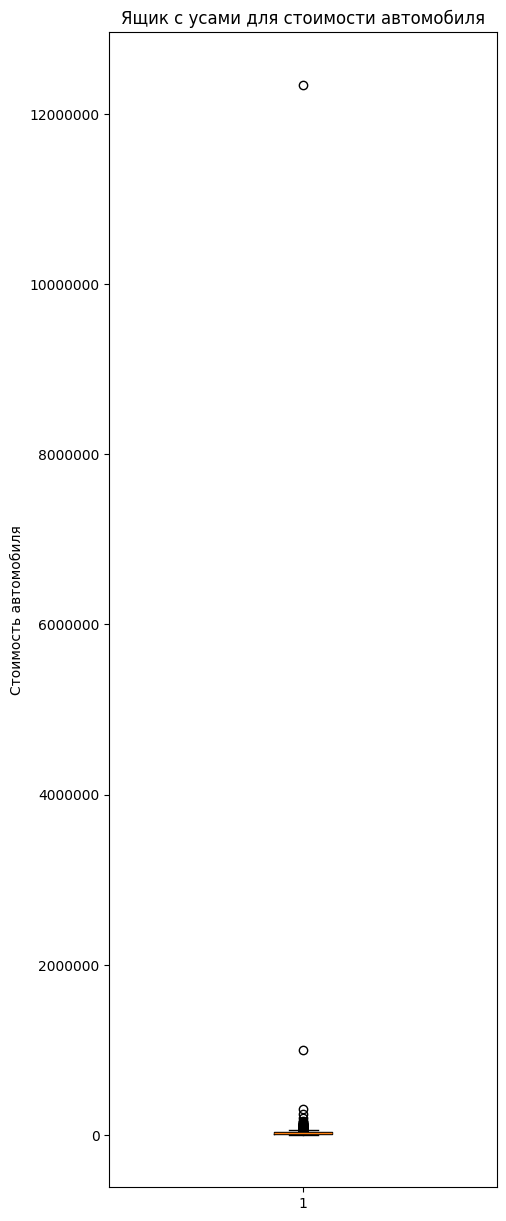

In [51]:
# «ящик с усами» для стоимости автобомиля
fig,ax = plt.subplots(figsize=(5,15))
ax.boxplot(df.price)

ax.set_ylabel("Стоимость автомобиля")
ax.set_title("Ящик с усами для стоимости автомобиля")

ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"));

In [52]:
# описательные статистики стоимости автомобиля
df.price.describe().apply(lambda x: f"{x:0.3f}")

count        9868.000
mean        20602.005
std        125437.186
min           500.000
25%          7800.000
50%         15590.000
75%         27990.000
max      12345678.000
Name: price, dtype: object

In [53]:
# границы для нормальных значений стоимости автомобиля
def calculate_outliers(data):   
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5*iqr,
                  q75 + 1.5*iqr)
    return boundaries

In [54]:
boundaries = calculate_outliers(df.price)
boundaries

(-22485.0, 58275.0)

In [55]:
# количество выбросов в стоимости автомобиля
is_outlier = (df.price<boundaries[0])|(df.price>boundaries[1])
is_outlier.sum()

207

In [56]:
# записи, в которых стоимость автомобиля попадает в выбросы
df_outlier = df[is_outlier].sort_values("price")
df_outlier.tail(10)

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
6566,7312384300,https://orlando.craigslist.org/ctd/d/orlando-2...,orlando,https://orlando.craigslist.org,129999,2018,mercedes-benz,maybach s560,gas,6000,clean,automatic,https://images.craigslist.org/00u0u_fKyDNpMeQR...,"Serious/ready buyers, please call or text @ (4...",fl,28.463700,-81.394800,2021-04-25 16:58:01+00:00,high,2021-04-25 16:58:01+00:00
9024,7314817013,https://sandiego.craigslist.org/csd/ctd/d/dall...,san diego,https://sandiego.craigslist.org,139950,2017,other,Mclaren 570GT W/ Upgrades,gas,13000,clean,automatic,https://images.craigslist.org/00N0N_2egaCVi4pq...,SPECIALTYEXOTICS.COMCALL/TXT 469-215-1902FREE ...,ca,32.790400,-96.804400,2021-04-30 15:20:20+00:00,high,2021-04-30 15:20:20+00:00
4245,7316319465,https://portland.craigslist.org/clc/ctd/d/glad...,portland,https://portland.craigslist.org,149990,2015,mercedes-benz,sprinter 3500 airs,diesel,49291,clean,automatic,https://images.craigslist.org/00B0B_79v5I132cL...,2015 Mercedes-Benz Sprinter 3500 Airstream Int...,or,45.382346,-122.605132,2021-05-03 18:04:09+00:00,high,2021-05-03 18:04:09+00:00
8840,7313664504,https://austin.craigslist.org/cto/d/austin-sup...,austin,https://austin.craigslist.org,150000,2006,other,Peterbilt 378,diesel,1234,clean,manual,https://images.craigslist.org/00v0v_ejAvqrK3iP...,Selling a Wonderful Super Dump! 2006 Peterbilt...,tx,30.364900,-97.682700,2021-04-28 02:01:28+00:00,high,2021-04-28 02:01:28+00:00
9164,7306718413,https://desmoines.craigslist.org/ctd/d/portlan...,des moines,https://desmoines.craigslist.org,163540,2020,mercedes-benz,other,other,6318,clean,automatic,https://images.craigslist.org/00y0y_i26NvL7pZC...,2020 *** Mercedes-Benz G-Class G63 AMG*** ...,ia,45.494265,-122.579192,2021-04-14 16:26:24+00:00,high,2021-04-14 16:26:24+00:00
6121,7315323093,https://daytona.craigslist.org/ctd/d/orlando-2...,daytona beach,https://daytona.craigslist.org,197999,2015,other,Lamborghini Huracan,gas,33875,clean,other,https://images.craigslist.org/01717_55Ai9omMq5...,CREDIT AMNESTY! SE HABLA ESPANOL !!OPEN SUNDA...,fl,28.466088,-81.396429,2021-05-01 15:48:44+00:00,high,2021-05-01 15:48:44+00:00
292,7310897583,https://tucson.craigslist.org/ctd/d/tucson-201...,tucson,https://tucson.craigslist.org,239995,2017,ferrari,488 gtb,gas,6012,clean,automatic,https://images.craigslist.org/00t0t_dN5Wr8nfOx...,2017 Ferrari 488 GTB Coupe2017 Ferrari 488 GTB...,az,32.236075,-110.878886,2021-04-22 16:38:59+00:00,high,2021-04-22 16:38:59+00:00
5662,7313998757,https://winchester.craigslist.org/ctd/d/manass...,winchester,https://winchester.craigslist.org,304995,2021,porsche,911,gas,22,clean,automatic,https://images.craigslist.org/00r0r_gh2TnrNdSu...,2021 PORSCHE 911 Turbo Offered by: Insider...,va,38.762669,-77.461754,2021-04-28 19:49:25+00:00,high,2021-04-28 19:49:25+00:00
9792,7305237859,https://delaware.craigslist.org/cto/d/delaware...,delaware,https://delaware.craigslist.org,1000000,2022,other,Any make any model,other,283466,clean,other,https://images.craigslist.org/00S0S_k3A68PVXRC...,We come to you and give you an easy quick tran...,de,39.572500,-75.595700,2021-04-11 17:51:42+00:00,high,2021-04-11 17:51:42+00:00
6331,7302112231,https://akroncanton.craigslist.org/ctd/d/canto...,akron / canton,https://akroncanton.craigslist.org,12345678,2019,chevrolet,other,gas,100000,clean,automatic,https://images.craigslist.org/00F0F_g6k0zWbump...,"WE HAVE MOVED TO 2517 FULTON DRIVE NW CANTON, ...",oh,40.846500,-81.440800,2021-04-05 16:26:23+00:00,high,2021-04-05 16:26:23+00:00


In [57]:
# удалим все аномальные значения
df = df[~(is_outlier)]

In [58]:
df.shape

(9661, 20)

# 3. Feature engineering

## Построение признаков из строк

In [59]:
# список значений и количество уникальных значений для модели автомобиля
print("Список значений:", df["model"].value_counts())
print("Количество уникальных значений:", df["model"].nunique())

Список значений: model
f-150                        145
other                        107
silverado 1500               106
1500                          99
camry                         76
                            ... 
c-max hybrid sel wagon 4d      1
grand caravan sport            1
Nascar                         1
titan le                       1
a3 2.0t premium plus pzev      1
Name: count, Length: 3358, dtype: int64
Количество уникальных значений: 3358


In [60]:
# создаем новый признак `short_model`, содержащий только первое слово из наименования модели
df["short_model"] = df["model"].apply(lambda x: x.split(" ")[0])
print(df["short_model"])
print("Количество уникальных значений:", df["short_model"].nunique())

0           2500
1       explorer
2           golf
3           rav4
4         altima
          ...   
9995        rav4
9996    wrangler
9997          a3
9998     cayenne
9999        1500
Name: short_model, Length: 9661, dtype: object
Количество уникальных значений: 949


In [61]:
# новые признаки
df['model_len'] = df.apply(lambda x: len(x.model) , axis=1)
df['model_word_count'] = df.apply(lambda x: len(x.model.split(' ')), axis=1)
df['odometer/price'] = df.apply(lambda x: x.odometer / x.price, axis=1) # количество пройденных мил ь к стоимости автомобиля
df['desc_len'] = df.apply(lambda x: len(x.description), axis = 1) # количество символов в описании автомобиля
df['model_in_desc'] = df.apply(lambda x: x.description.count(x.model), axis = 1) # как часто наименование модели автомобиля встречается в описании
df['odometer_km'] = df.apply(lambda x: x.odometer * 1.609344, axis=1) # значение в км
df['region_new'] = df.region_url.apply(lambda x: x.lower().split('://')[1].split('.')[0]) # регион из Url адреса
df['region_corrected'] = df['region'].apply(lambda x: x.lower().split('/')[0].replace(' ', '').replace('-', '')) # преобразуем исходный регион
df['manufacturer_model'] = df.manufacturer + ': ' + df.model # производитель и модель в одной колонке
df['price_k$'] = df.apply(lambda x: round(x.price / 1000) , axis=1) # cтоимость автомобиля в тысячах долларов

## Построение категориального признака на основе количественного

In [62]:
# Создаем новый признак `age_category`, обозначающий возрастную категорию автомобиля
df['age_category'] =  df.apply(lambda x: "new" if x.year > 2013 else ("old" if x.year < 2006 else "average"), axis=1)
df['age_category']

0           new
1           new
2           new
3       average
4           new
         ...   
9995        old
9996    average
9997    average
9998        new
9999        new
Name: age_category, Length: 9661, dtype: object

In [63]:
df[['year', 'age_category']]

,year,age_category
0,2020,new
1,2016,new
2,2017,new
3,2013,average
4,2021,new
...,...,...
9995,2002,old
9996,2008,average
9997,2011,average
9998,2015,new


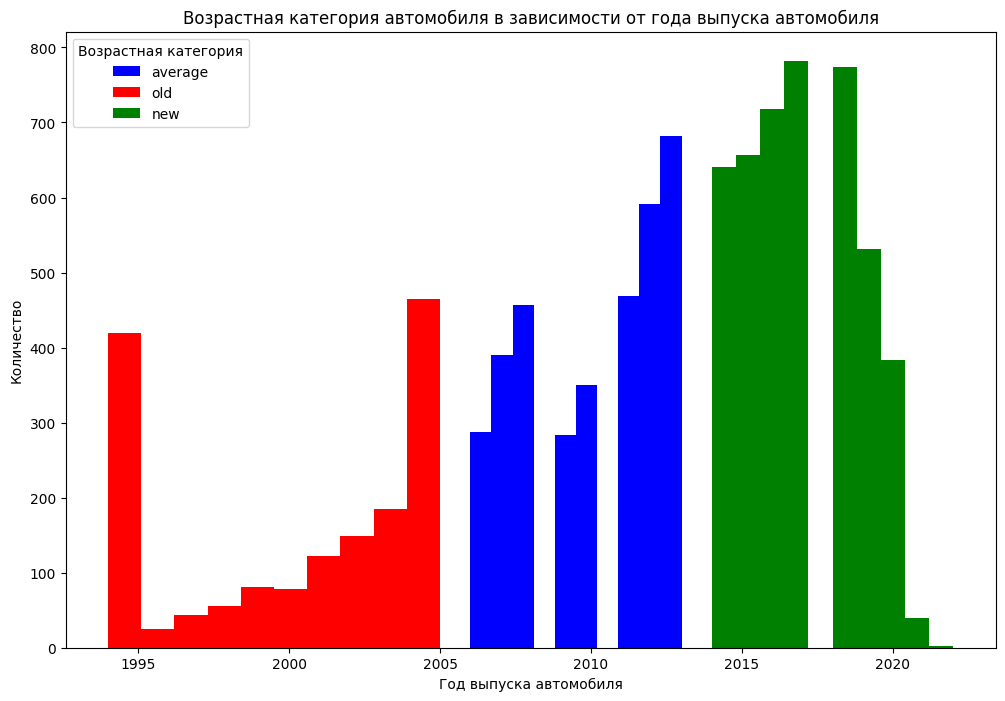

In [64]:
# графики распределения года производства автомобиля для каждой из возрастной категории автомобиля
colors = {'average': 'blue', 'old': 'red', 'new': 'green'}

fig, ax = plt.subplots(figsize=(12, 8))
for age_category in colors:
    color = colors[age_category]
    data = df[df['age_category'] == age_category]

    ax.hist(data['year'], color=color)
    
plt.ylabel('Количество')
plt.xlabel('Год выпуска автомобиля')
plt.title('Возрастная категория автомобиля в зависимости от года выпуска автомобиля')
plt.legend(colors, title="Возрастная категория");

## Создание нескольких признаков из категориальной переменной

In [65]:
manufacturer_names = ['audi', 'ford', 'chevrolet', 'toyota', 'jeep', 'honda', 'nissan']

for manufacturer in manufacturer_names:
    col_name = 'is_' + manufacturer

    df[col_name] = df.apply(lambda x: 1 if x.manufacturer == manufacturer else 0, axis=1)

In [66]:
df.iloc[:, -7:]

,is_audi,is_ford,is_chevrolet,is_toyota,is_jeep,is_honda,is_nissan
0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
9995,0,0,0,1,0,0,0
9996,0,0,0,0,1,0,0
9997,1,0,0,0,0,0,0
9998,0,0,0,0,0,0,0


## Преобразование категориальных переменных

In [67]:
# для категориальных переменных распечатаем наименование категории и количество уникальных значений в ней
columns = ["short_model", "transmission", "region", "manufacturer", "state", "title_status", 'age_category']
for elem in columns:
    print("Характеристика:", elem)
    print("Количество уникальных значений:", df[elem].nunique())

Характеристика: short_model
Количество уникальных значений: 949
Характеристика: transmission
Количество уникальных значений: 3
Характеристика: region
Количество уникальных значений: 393
Характеристика: manufacturer
Количество уникальных значений: 40
Характеристика: state
Количество уникальных значений: 51
Характеристика: title_status
Количество уникальных значений: 6
Характеристика: age_category
Количество уникальных значений: 3


In [68]:
# Создаем датафрейм `data`, содержащий только выбранные категориальные переменные
data = df[["short_model", "transmission", "region", "manufacturer", "state", "title_status", 'age_category']].copy()

In [69]:
data

,short_model,transmission,region,manufacturer,state,title_status,age_category
0,2500,other,chattanooga,ram,tn,clean,new
1,explorer,automatic,north jersey,ford,nj,clean,new
2,golf,other,reno / tahoe,volkswagen,ca,clean,new
3,rav4,automatic,fayetteville,toyota,nc,clean,average
4,altima,automatic,new york city,nissan,ny,clean,new
...,...,...,...,...,...,...,...
9995,rav4,automatic,chautauqua,toyota,ny,clean,old
9996,wrangler,other,binghamton,jeep,ny,clean,average
9997,a3,automatic,salem,audi,or,clean,average
9998,cayenne,automatic,madison,porsche,wi,clean,new


In [70]:
# преобразование для датафрейма с категориальными переменными
ohe = OneHotEncoder(sparse_output=False)
ohe_new = ohe.fit_transform(data)
ohe_new

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [71]:
ohe_new.shape

(9661, 1445)

In [72]:
# новые наименования признаков
ohe.get_feature_names_out()

array(['short_model_-benz', 'short_model_1', 'short_model_124', ...,
       'age_category_average', 'age_category_new', 'age_category_old'],
      dtype=object)

In [74]:
# добавим в исходный датафрейм получившиеся новые признаки
df[ohe.get_feature_names_out()] = ohe_new
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,state_wy,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,age_category_average,age_category_new,age_category_old
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Стандартизация данных

In [75]:
# Создаем переменную под количественные переменные
variable = df[["lat", "long", "year", "odometer/price", "desc_len", "model_in_desc", "model_len", "model_word_count"]]
data2 = df[["lat", "long", "year", "odometer/price", "desc_len", "model_in_desc", "model_len", "model_word_count"]]

In [76]:
# преобразование для датафрейма с количественными переменными
std_scaler = StandardScaler()
std_scaled = std_scaler.fit_transform(data2)

In [77]:
# наименования новых признаков
variable_2 = ["lat_std", 
      "long_std", 
      "year_std", 
      "odometer/price_std", 
      "desc_len_std", 
      "model_in_desc_std", 
      "model_len_std", 
      "model_word_count_std"]
variable_2

['lat_std',
 'long_std',
 'year_std',
 'odometer/price_std',
 'desc_len_std',
 'model_in_desc_std',
 'model_len_std',
 'model_word_count_std']

In [79]:
# Добавим в исходный датафрейм получившиеся новые признаки
df[variable_2] = std_scaled

## MinMax-нормализация данных

In [80]:
# датафрейм, содержащий широту и долготу
data3 = df[["lat", "long"]]
data3

,lat,long
0,35.060000,-85.250000
1,40.821805,-74.061962
2,33.779214,-84.411811
3,35.715954,-78.655304
4,40.654800,-73.609700
...,...,...
9995,42.123900,-79.189500
9996,43.216990,-77.755610
9997,44.925908,-122.982753
9998,43.029559,-89.397796


In [82]:
# преобразование для датафрейма с нормализацией данных
std_MM = MinMaxScaler()
std_MM = std_MM.fit_transform(data3)
variable_3 = ["lat_mm", "long_mm"]
df[variable_3] = std_MM

In [83]:
# географические признаки
variable_4 = df[["lat", "lat_std", "lat_mm", "long", "long_std", "long_mm"]]
variable_4

,lat,lat_std,lat_mm,long,long_std,long_mm
0,35.060000,-0.618480,0.341769,-85.250000,0.485719,0.288699
1,40.821805,0.388145,0.468665,-74.061962,1.111829,0.333055
2,33.779214,-0.842241,0.313561,-84.411811,0.532626,0.292022
3,35.715954,-0.503880,0.356215,-78.655304,0.854774,0.314844
4,40.654800,0.358968,0.464987,-73.609700,1.137139,0.334848
...,...,...,...,...,...,...
9995,42.123900,0.615629,0.497341,-79.189500,0.824879,0.312727
9996,43.216990,0.806599,0.521415,-77.755610,0.905123,0.318411
9997,44.925908,1.105158,0.559052,-122.982753,-1.625898,0.139104
9998,43.029559,0.773854,0.517287,-89.397796,0.253598,0.272255


In [84]:
# матрица корреляций для всех географических признаков
variable_4.corr()

,lat,lat_std,lat_mm,long,long_std,long_mm
lat,1.000000,1.000000,1.000000,-0.134123,-0.134123,-0.134123
lat_std,1.000000,1.000000,1.000000,-0.134123,-0.134123,-0.134123
lat_mm,1.000000,1.000000,1.000000,-0.134123,-0.134123,-0.134123
long,-0.134123,-0.134123,-0.134123,1.000000,1.000000,1.000000
long_std,-0.134123,-0.134123,-0.134123,1.000000,1.000000,1.000000
long_mm,-0.134123,-0.134123,-0.134123,1.000000,1.000000,1.000000


## Признаки на основе дат

In [85]:
df["date"] = pd.to_datetime(df["date"])
df["date"]

0      2021-04-17 16:30:50+00:00
1      2021-05-03 19:40:21+00:00
2      2021-04-28 10:52:20+00:00
3      2021-04-17 14:08:57+00:00
4      2021-05-03 22:32:06+00:00
                  ...           
9995   2021-04-10 20:33:57+00:00
9996   2021-05-03 13:36:30+00:00
9997   2021-04-22 19:14:01+00:00
9998   2021-04-14 14:14:42+00:00
9999   2021-04-24 17:50:49+00:00
Name: date, Length: 9661, dtype: datetime64[ns, UTC]

In [87]:
df["month"] = df["date"].dt.month # номер месяца размещения объявления о продаже автомобиля
df["dayofweek"] = df["date"].dt.dayofweek # день недели размещения объявления о продаже автомобиля
df["diff_years"] = df["posting_date"] - df["date"] # количество лет между годом производства автомобиля и годом размещения объявления о продаже автомобиля

In [88]:
# стандартизация к полученным признаками
std_scaler_2 = StandardScaler()
data4 = df[["month", "dayofweek", "diff_years"]]
data4.diff_years = pd.to_numeric(data4.diff_years)
data4.dtypes

C:\Users\krugd\AppData\Local\Temp\ipykernel_25932\321213047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4.diff_years = pd.to_numeric(data4.diff_years)


month         int32
dayofweek     int32
diff_years    int64
dtype: object

In [90]:
std_scaler_2 = StandardScaler()
std_scaled_2 = std_scaler_2.fit_transform(data4)
variable_6 = data4.columns.map(lambda x: x + "_std")
df[variable_6] = std_scaled_2

## Датафрейм для этапа моделирования

In [91]:
columns_for_drop = ['year', 'url', 'region', 'region_url', 'manufacturer',
                    'model', 'fuel', 'odometer', 'title_status', 'transmission',
                    'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
                    'odometer_km', 'odometer/price', 'region_new', 'region_corrected', 'manufacturer_model',
                    'desc_len', 'model_in_desc', 'price_k$', 'age_category', 'model_len', 'model_word_count',
                    'short_model', 'lat_mm', 'long_mm', 'date',
                    'month', 'dayofweek', 'diff_years',
                    'odometer/price_std']
df_prepared = df.drop(columns =columns_for_drop, axis=1)

# 4. Modelling

## Модель логистической регрессии

### Обучение модели

In [143]:
df_prepared.shape

(9661, 1465)

In [133]:
# подготовка данных
df_prepared_for_model = df_prepared.drop(["price", "id"], axis=1)

In [134]:
# инициализация входных фичей и целевой переменной
x = df_prepared_for_model.drop(["price_category"], axis=1)
y = df_prepared_for_model["price_category"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [135]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

c:\Users\krugd\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [141]:
# качество на тренировочных данных
logreg.score(x_train, y_train)

0.8250517598343685

### Тюнинг параметров

In [137]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [138]:
logreg_tuned = LogisticRegression(C = 3.0, penalty='l2', solver='newton-cg', random_state = 42)

In [139]:
logreg_tuned.fit(x_train, y_train)

LogisticRegression(C=3.0, random_state=42, solver='newton-cg')

In [142]:
# качество на тренировочных данных
logreg_tuned.score(x_train, y_train)

0.8484176279207335

### Проверка качества с помощью кросс-валидации

In [144]:
cross_validate(logreg_tuned, x, y, cv=6)

{'fit_time': array([7.83924437, 6.85841155, 7.17542481, 7.60832739, 8.08877373,
        7.6616962 ]),
 'score_time': array([0.0240221 , 0.02502275, 0.02402186, 0.02502227, 0.02602386,
        0.02402186]),
 'test_score': array([0.74736189, 0.76024845, 0.71863354, 0.74161491, 0.74099379,
        0.74596273])}

In [145]:
cv_score = cross_val_score(logreg_tuned, x, y, cv=6)

In [146]:
cv_score.mean(), cv_score.std()

(0.74246921719596, 0.012404905713798627)

## Модель случайного леса

### Обучение модели

In [147]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [148]:
# качество на тренировочных данных
rf_clf.score(x_train, y_train)

1.0

### Проверка качества с помощью кросс-валидации

In [152]:
cross_validate(rf_clf, x, y, cv=6)

{'fit_time': array([5.54174256, 5.25989509, 5.24493337, 5.20341277, 5.26919436,
        5.13261032]),
 'score_time': array([0.06806135, 0.06806183, 0.06605959, 0.06803465, 0.06656408,
        0.06605983]),
 'test_score': array([0.74860335, 0.76149068, 0.73913043, 0.76708075, 0.75900621,
        0.74782609])}

In [153]:
cv_score = cross_val_score(rf_clf, x, y, cv=6)

In [154]:
cv_score.mean(), cv_score.std()

(0.7538562522409985, 0.009491218625245604)

### Тюним параметры с помощью "GridSearchCV"

In [156]:
param_grid = {
    'n_estimators': list(range(100, 501, 100)),
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': list(range(1, 10))
}

In [157]:
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

In [158]:
grid_search_rf.fit(x_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=1)

In [159]:
best_params = grid_search_rf.best_params_
best_params

{'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 400}

In [160]:
rf_tuned = RandomForestClassifier(max_features='log2', min_samples_leaf=1, n_estimators=400)
rf_tuned.fit(x_train, y_train)

RandomForestClassifier(max_features='log2', n_estimators=400)

### Проверка качества с помощью кросс-валидации

In [161]:
cross_validate(rf_tuned, x, y, cv=6)

{'fit_time': array([19.24677825, 18.39002991, 18.01537347, 17.96732855, 17.97633767,
        17.91428137]),
 'score_time': array([0.26855421, 0.22720671, 0.24322104, 0.22520518, 0.23321199,
        0.23721576]),
 'test_score': array([0.75729361, 0.75776398, 0.7447205 , 0.7689441 , 0.76335404,
        0.73540373])}

In [162]:
cv_score = cross_val_score(rf_tuned, x, y, cv=6)

In [163]:
cv_score.mean(), cv_score.std()

(0.754890613574121, 0.011250870076190937)

## Модель многослойный персептрон

### Обучение модели

In [164]:
mlp = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(100, 20), activation="tanh")

In [165]:
mlp.fit(x_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 20), max_iter=500,
              random_state=42)

In [166]:
mlp.get_params()

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100, 20),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

### Проверка качества с помощью кросс-валидации

In [167]:
cross_validate(mlp, x, y, cv=6)

{'fit_time': array([50.86364102, 52.15365767, 47.10865927, 44.84324765, 54.25835776,
        58.14341092]),
 'score_time': array([0.02902746, 0.02702379, 0.02702069, 0.02702427, 0.0280242 ,
        0.02902603]),
 'test_score': array([0.74984482, 0.75341615, 0.7310559 , 0.74782609, 0.74037267,
        0.7515528 ])}

In [168]:
cv_score = cross_val_score(mlp, x, y, cv=6)

In [169]:
cv_score.mean(), cv_score.std()

(0.7456780698947325, 0.007727883671434112)

## Значение метрики лучшей модели на тестовой выборке

In [170]:
preds = rf_tuned.predict(x_test)
accuracy_score(y_test, preds)
print(f'Tuned RF Model Accuracy: {accuracy_score(y_test, preds):.5f}')

Tuned RF Model Accuracy: 0.73577


# 5. Results

*Итог:* модель случайного леса с тюниными параметрами показала себя лучше всего

In [179]:
rf_tuned.fit(x, y)

RandomForestClassifier(max_features='log2', n_estimators=400)

In [180]:
filename = 'model.pickle'

with open (filename, 'wb') as file:
    pickle.dump(rf_tuned, file)